In [1]:
import sys
sys.path.append('/home/jovyan/work/_Headline_generation/News_Headline_Generation/')

In [114]:
import numpy as np
import rouge
from tqdm import tqdm, trange
from multiprocessing import Pool
from joblib import Parallel, delayed
import re
from ipymarkup import show_markup
from itertools import chain
import matplotlib.pyplot as plt
from collections import Counter
import heapq
%matplotlib inline
from termcolor import colored

In [79]:
import utils
import imp
imp.reload(utils)

<module 'utils' from '/home/jovyan/work/_Headline_generation/News_Headline_Generation/utils.py'>

In [4]:
%%time
texts, titles = utils.load_data('/home/jovyan/work/_Headline_generation/ria.json')

1003869it [00:56, 17722.92it/s]


CPU times: user 50.8 s, sys: 6.42 s, total: 57.2 s
Wall time: 56.6 s


In [5]:
pool = Pool(10)

In [6]:
parsed = pool.map(utils.parse_source, tqdm(texts))

100%|██████████| 1003869/1003869 [01:34<00:00, 10619.58it/s]


## Первые предложения

In [22]:
tokenizer = utils.FirstSentenceTokenizer()
first_sentences = [tokenizer.tokenize(_) for _ in tqdm(parsed)]

100%|██████████| 1003869/1003869 [00:54<00:00, 18545.54it/s]


In [23]:
lengths = [len(_) for _ in first_sentences]

In [24]:
min(lengths)

0

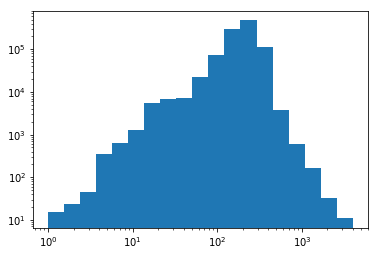

In [25]:
plt.hist(lengths, bins=np.logspace(0, 3.6, 20))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

### Получение словаря

In [ ]:
from collections import Counter

In [ ]:
regex_word = re.compile('[а-яёa-z\-]+')
freq = Counter()
for sentence in tqdm(first_sentences):
    for word in regex_word.findall(sentence):
        freq[word] += 1

In [ ]:
freq.most_common(100)

In [ ]:
plt.hist(list(freq.values()), bins=np.logspace(0, 6.3, 20))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [ ]:
all_words = sum(freq.values())
top_words = sum(_[1] for _ in freq.most_common(50000))
top_words / all_words

### Получение скоров без фильтрации редких слов

In [26]:
from rouge import Rouge 
scorer = Rouge()

In [27]:
first_sentences = [first_sentences[i] if len(first_sentences[i]) > 3 else titles[i] for i in range(len(first_sentences)) ]

In [28]:
min(len(_) for _ in titles)

6

In [29]:
titles = [titles[i] if len(titles[i]) > 5 else 'а'*20 for i in range(len(titles)) ]

In [30]:
lengths = [len(_) for _ in first_sentences]
min(lengths)

4

In [31]:
%%time
scorer.get_scores(first_sentences, titles, avg=True)

CPU times: user 7min 55s, sys: 2.09 s, total: 7min 57s
Wall time: 7min 56s


{'rouge-1': {'f': 0.2486609340575932,
  'p': 0.1749548838258469,
  'r': 0.4695426866963995},
 'rouge-2': {'f': 0.11076440032561513,
  'p': 0.0766843257758511,
  'r': 0.22291123126761683},
 'rouge-l': {'f': 0.17336727901459906,
  'p': 0.1606306228037659,
  'r': 0.4301897932667798}}

In [82]:
(0.2486609340575932+0.11076440032561513+0.17336727901459906)/3

0.17759753779926912

In [32]:
first_sentences[2]

'до 7 февраля - того дня, когда граждане украины решат, кто на ближайшие пять лет возьмет бразды правления страной в свои руки, - осталась ровно неделя'

### Получение скоров с фильтрацией редких слов

Получим словарь

In [51]:
vocab = utils.get_vocab(chain(titles, first_sentences))

2007738it [00:45, 44219.59it/s]


Отфильтруем самые частые слова

In [52]:
vocab_top_frequent = utils.filter_vocab(vocab, n=50000)

Получим заголовки и первые предложения без знаков препинания и редких слов

In [53]:
titles_filtered = utils.filter_texts(titles, vocab_top_frequent)
first_sentences_filtered = utils.filter_texts(first_sentences, vocab_top_frequent)

100%|██████████| 1003869/1003869 [00:23<00:00, 42232.16it/s]


In [57]:
titles_filtered = [titles_filtered[i] if len(titles_filtered[i]) > 5 else 'а'*20 for i in range(len(titles_filtered)) ]
first_sentences_filtered = [first_sentences_filtered[i] if len(first_sentences_filtered[i]) > 3 else titles_filtered[i] for i in range(len(first_sentences_filtered)) ]

In [62]:
%%time
scorer.get_scores(first_sentences_filtered, titles_filtered, avg=True)

CPU times: user 6min 57s, sys: 1.51 s, total: 6min 59s
Wall time: 6min 58s


{'rouge-1': {'f': 0.2842236396665328,
  'p': 0.2000193040853728,
  'r': 0.5414221130501112},
 'rouge-2': {'f': 0.12612636548805686,
  'p': 0.08720967178968597,
  'r': 0.257567061552075},
 'rouge-l': {'f': 0.19571938456778085,
  'p': 0.18177296712670088,
  'r': 0.4906582209423502}}

In [84]:
(0.2842236396665328+0.12612636548805686+0.19571938456778085)/3

0.20202312990745683

### Получение скоров с сохранением пунктуации

In [80]:
titles_filtered = utils.filter_texts_with_punctuation_spaces(titles, vocab_top_frequent)
first_sentences_filtered = utils.filter_texts_with_punctuation_spaces(first_sentences, vocab_top_frequent)
titles_filtered = [titles_filtered[i] if len(titles_filtered[i]) > 5 else 'а'*20 for i in range(len(titles_filtered)) ]
first_sentences_filtered = [first_sentences_filtered[i] if len(first_sentences_filtered[i]) > 3 else titles_filtered[i] for i in range(len(first_sentences_filtered)) ]


100%|██████████| 1003869/1003869 [00:40<00:00, 24493.04it/s]


In [81]:
%%time
scorer.get_scores(first_sentences_filtered, titles_filtered, avg=True)

CPU times: user 7min 33s, sys: 1.77 s, total: 7min 34s
Wall time: 7min 33s


{'rouge-1': {'f': 0.25675646704517774,
  'p': 0.18067755018686546,
  'r': 0.49011926614274137},
 'rouge-2': {'f': 0.11654683276540687,
  'p': 0.08114441280707248,
  'r': 0.23452119002988178},
 'rouge-l': {'f': 0.17894743541237113,
  'p': 0.16617113221318203,
  'r': 0.44973780457592655}}

Получим также скоры для каждого предложения отдельно и найдем наихудшие

In [88]:
scores_single = [scorer.get_scores(first_sentences_filtered[i], titles_filtered[i]) for i in trange(len(first_sentences_filtered))]

100%|██████████| 1003869/1003869 [08:05<00:00, 2066.95it/s]


In [91]:
max(len(_) for _ in scores_single)

1

In [98]:
scores_single[0][0]['rouge-1']['f'] + scores_single[0][0]['rouge-2']['f'] + scores_single[0][0]['rouge-l']['f']

0.41619560796253974

In [139]:
def mean_f1(x):
    return (x[1][0]['rouge-1']['f'] + x[1][0]['rouge-2']['f'] + x[1][0]['rouge-l']['f']) / 3
worst = heapq.nsmallest(10000, enumerate(scores_single), key=mean_f1)

In [161]:
j = np.random.choice(len(worst))
i = worst[j][0]
f1 = mean_f1(worst[j])
print('Средняя F-мера:', f1)
print(colored(f'Первое предложение: {first_sentences[i]}', color='green'))
print('Отфильтрованное первое предложение:', first_sentences_filtered[i])
print(colored(f'Заголовок: {titles[i]}', color='green'))
print('Отфильтрованный заголовок:', titles_filtered[i])

print(colored(f'Текст без тегов:\n {parsed[i]}', color='blue'))

Средняя F-мера: 0.0
Первое предложение: do tej pory płaczę myśląc o tej tragedii
Отфильтрованное первое предложение: do tej p my l c o tej tragedii
Заголовок: аааааааааааааааааааа
Отфильтрованный заголовок: аааааааааааааааааааа
Текст без тегов:
 do tej pory płaczę myśląc o tej tragedii. szok i przerażenie pierwszych godzin zastąpiły żal i współczucie. przyjmijcie nasze kondolencje. i niech pan bóg da naszym krajom pokój i wzajemne zrozumienie!


In [162]:
best = heapq.nlargest(10000, enumerate(scores_single), key=mean_f1)

In [165]:
j = np.random.choice(len(best))
i = best[j][0]
f1 = mean_f1(best[j])
print('Средняя F-мера:', f1)
print(colored(f'Первое предложение: {first_sentences[i]}', color='green'))
print('Отфильтрованное первое предложение:', first_sentences_filtered[i])
print(colored(f'Заголовок: {titles[i]}', color='green'))
print('Отфильтрованный заголовок:', titles_filtered[i])

print(colored(f'Текст без тегов:\n {parsed[i]}', color='blue'))

Средняя F-мера: 0.7414874595859814
Первое предложение: сорок человек эвакуировали в уфе из-за пожара на крыше жилого дома, сообщается на сайте мчс рф
Отфильтрованное первое предложение: сорок человек эвакуировали в уфе из-за пожара на крыше жилого дома, сообщается на сайте мчс рф
Заголовок: сорок человек эвакуировали в уфе из-за пожара на крыше жилого дома
Отфильтрованный заголовок: сорок человек эвакуировали в уфе из-за пожара на крыше жилого дома
Текст без тегов:
 
москва, 28 дек — риа новости. сорок человек эвакуировали в уфе из-за пожара на крыше жилого дома, сообщается на сайте мчс рф.
информация о возгорании на крыше дома 34 по улице султанова поступила в четверг в 21.33 мск. спустя час огонь был локализован на площади 600 квадратных метров. спасатели эвакуировали 40 жильцов.
"в 00.53 мск 28 декабря пожар ликвидирован. погибших и пострадавших нет", — говорится на сайте.


Типичные причины низких скоров:
* Первое предложение распознано неправильно из-за ошибок в тексте. Часто в заметках есть типовое предложение вида `петропавловск-камчатский, 7 янв - риа новости`. Его мы пропускаем и в качестве гипотезы берем следующее предложение. Регулярка, который мы ищем это типовое предложение, срабатывает не всегда. Например, `петропавловск-камчатский, 7 янв- риа новости` - здесь должен быть пробел перед тире. Также было, что после названия города стоит точка, а не запятая.
* Первое предложение заметно длиннее заголовка
* Есть тексты, отличающиеся от типичных новостных заметок (записи в блоге, аналитика, письма читателей). Они написаны более свободным стилем, и первое предложение может не содержать обобщения статьи.

Проанализируем, как метрика зависит от разности длин

In [134]:
len_diff = [abs(len(x) - len(y)) + 1 for x, y in zip(first_sentences_filtered, titles_filtered)]
f1 = [mean_f1(_) for _ in enumerate(scores_single)]

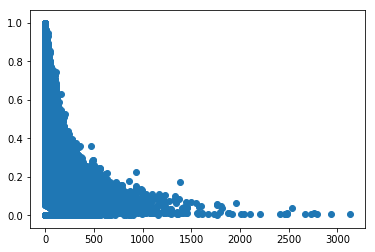

In [135]:
plt.scatter(len_diff, f1)

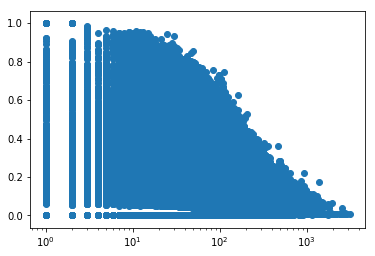

In [136]:
plt.scatter(len_diff, f1)
plt.gca().set_xscale('log')

In [133]:
np.corrcoef(len_diff, f1), np.corrcoef(np.log1p(len_diff), f1)

(array([[ 1.        , -0.27873493],
        [-0.27873493,  1.        ]]), array([[ 1.        , -0.24160674],
        [-0.24160674,  1.        ]]))

In [83]:
(0.25675646704517774+0.11654683276540687+0.17894743541237113)/3

0.1840835784076519

### Уникальные символы

In [34]:
symbols = ''.join({c for text in tqdm(chain(first_sentences, titles), total=len(titles) + len(first_sentences)) for c in text})

100%|██████████| 2007738/2007738 [00:33<00:00, 59274.35it/s]


In [37]:
sorted(_ for _ in symbols if not _.isalnum())

['\t',
 '\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '\x96',
 '\x98',
 '\xa0',
 '¡',
 '£',
 '¤',
 '©',
 '«',
 '¬',
 '\xad',
 '®',
 '°',
 '¸',
 '»',
 '×',
 '˚',
 '́',
 '̆',
 '̇',
 '\u200b',
 '\u200e',
 '\u200f',
 '‐',
 '‑',
 '–',
 '—',
 '―',
 '‘',
 '’',
 '“',
 '”',
 '„',
 '•',
 '…',
 '\u202a',
 '′',
 '€',
 '№',
 '™',
 '−',
 '─',
 '╗',
 '\ufeff',
 '＄',
 '�']

In [39]:
symb_freq = Counter()
for text in tqdm(chain(first_sentences, titles), total=len(titles) + len(first_sentences)):
    for c in text:
        symb_freq[c] += 1

100%|██████████| 2007738/2007738 [03:14<00:00, 10317.05it/s]


In [59]:
symb_freq.most_common(100)

[(' ', 32005918),
 ('о', 23939338),
 ('и', 18469403),
 ('а', 18237326),
 ('е', 18017618),
 ('н', 14467269),
 ('р', 14095822),
 ('с', 13896311),
 ('т', 13307079),
 ('в', 11546841),
 ('л', 9067785),
 ('к', 7945272),
 ('п', 6791019),
 ('д', 6727731),
 ('м', 6322082),
 ('у', 5551596),
 ('г', 4249210),
 ('б', 4000556),
 ('я', 3549545),
 ('ы', 3439236),
 ('з', 3275300),
 ('й', 3116615),
 ('ь', 2704446),
 ('ч', 2208296),
 (',', 2193126),
 ('\xa0', 1725141),
 ('х', 1722640),
 ('ж', 1612129),
 ('ц', 1536346),
 ('"', 1281273),
 ('ф', 1197464),
 ('ш', 1196912),
 ('ю', 1111828),
 ('щ', 1064573),
 ('-', 841800),
 ('1', 517336),
 ('0', 506249),
 ('э', 494420),
 ('2', 435471),
 ('e', 224614),
 ('a', 220043),
 ('i', 204440),
 ('o', 179629),
 ('(', 178504),
 (')', 174979),
 ('5', 170927),
 ('3', 167642),
 ('r', 162101),
 ('s', 156804),
 ('n', 152618),
 ('t', 148334),
 ('4', 141145),
 (':', 129687),
 ('l', 107963),
 ('6', 98111),
 ('.', 97371),
 ('7', 94994),
 ('8', 94320),
 ('c', 93190),
 ('9', 90524),

In [49]:
''.join([_[0] for _ in symb_freq.most_common(200) if (not _[0].isalnum()) and (_[1] > 1000)])

' ,\xa0"-():.%—\n;–/$«?»!&\'№*>+'

In [ ]:
',"-():.%—\n;–/$«?»!&\'№*>+][…‑“”'

In [60]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
regex_punctuation_replace = re.compile('\s([!%,.:;?])')

In [77]:
regex_punctuation_replace.sub(r'\1', "авроы ! выапоц , pdsof")

'авроы! выапоц, pdsof'

In [87]:
first_sentences[np.random.choice(len(first_sentences))]

'для продолжения силовой операции в\xa0донбассе необходимо пополнение резервов военнослужащих, заявил в\xa0воскресенье в\xa0харькове министр обороны степан полторак, передает "радио свобода"'